In [24]:
import time
import numpy as np
import sympy as sp  
from math import *
import matplotlib.pyplot as plt
L_ig = sp.Symbol('lambda_ig')  # declaring symbol lambda_ig
L_i = sp.Symbol('lambda_i')
from tqdm import tqdm
from joblib import delayed, Parallel
import numpy as np
from scipy.integrate import quad
import math


# MAIN FUNCTION

In [23]:
# Prelimnary functions for rotation and distance between 2 points.
def Rotate(x2, y2, theta):
    X = (x2 * np.cos(theta) - y2 * np.sin(theta)) + X_displacement
    Y = (x2 * np.sin(theta) + y2 * np.cos(theta)) + Y_displacement
    return X, Y

def Distance(x1, y1, z1, x2, y2, z2):
    dis = sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)
    return dis

alp = 1.2
K_visc = 0.000015
del_s = 1000

In [25]:
# Function to compute the tensor product of two vectors a and b
def tensordot(a,b):
    tensor=np.zeros((3,3))
    for p in range(tensor.shape[0]):
        for q in range(tensor.shape[1]):
            tensor[p][q]=(a[p]-b[p])*(a[q]-b[q])
    return tensor

# Function to compute the skew-symmetric matrix of a vector a
def skew(a):
    x,y,z=list(a)
    tensor=np.array([[0,-z,y],[z,0,-x],[-y,x,0]])
    return tensor

# Function to compute the average distance between all pairs of points
def sigma(points):
    sigma=0
    for i in range(len(points)):
        for j in range(len(points)):
            if j!=i:
                x1,y1,z1=points[i]
                x2,y2,z2=points[j]
                sigma+=Distance(x1,y1,z1,x2,y2,z2)
    sigma/=len(points)**2
    return sigma

# Function to compute the Gaussian function \xi(n)
def E(n):
    return (2*np.pi)**(-3/2)*np.exp(-n**2/2)

# Function to compute the error function erf(s)
def erf(s):
    def integrand(x):
        return np.exp(-x**2)
    I = quad(integrand, 0, s)
    return I[0]

# Function to compute the Green's function G(rho)
def G(rho):
    try:
        k=1/(4*np.pi*rho)*erf(rho/2**0.5)
    except:
        k=0
    return k

# Function to compute the kernel function K(rho)
def K(rho):
    return (G(rho)-E(rho))/rho**2

# Function to compute the velocity of a single point in the fluid
def u(n, points, alpha0):
    sig=sigma(points)
    s=0
    x1,y1,z1=points[n]

    for i in range(len(points)):
        x2,y2,z2=points[i]
        if i!=n:
            rho=Distance(x1,y1,z1,x2,y2,z2)/sig

            z=np.cross(np.array(1/(sig)**3 * K(rho)*(np.array(points[n])-np.array(points[i]))), alpha0[i])
            s+=z

    return s*1

# Function to compute the derivative of the velocity of a single point in the fluid
def del_u(n, points, alpha0):
    sig=sigma(points)

    x1,y1,z1=points[n]
    s=0

    for i in range(len(points)):
        x2,y2,z2=points[i]
        if i!=n:
            rho=Distance(x1,y1,z1,x2,y2,z2)/sig

            F=(3*K(rho)-E(rho))/rho**2
            s+= np.matmul(skew(alpha0[i]) ,(np.array([[1,0,0],[0,1,0],[0,0,1]])*K(rho) - 1/sig**2 *F* tensordot(points[n], points[i])))

    return 1/sig**3 *s *1

# Function to compute the updated value of alpha0 for a single point in the fluid
def alpha(del_u, alpha0, points, n):
    visc=0.000015*100000
    sig=sigma(points)
    x1,y1,z1=points[n]
    s=0
    for i in range(len(points)):
        if i!=n:
            x2,y2,z2=points[i]
            s+=E(Distance(x1,y1,z1,x2,y2,z2))/sig**3 * (alpha0[n]-alpha0[i])*0.125

    return alpha0[n]+np.matmul(del_u, alpha0[n]) + 2*visc/sig**2 *s

# Final function to output velocities for the given set of points
def velocities(points, alpha0, vel0):
    velocities=list(np.array(vel0)+np.array([u(i, points, alpha0) for i in (range(len(points)))]))
    Alpha=[alpha(del_u(i, points, alpha0), alpha0, points, i) for i in (range(len(points)))]
    return velocities, Alpha
    


# CASE STUDIES

### FIXED WING CASE

In [18]:
# CODE DRIVER FOR FIXED WING CASE

# these points work as the wing, moving forward with constant velocity of 0.1 units/sec
org_points=[[i,-1.1,0] for i in range(11)]

points=[]
points+=org_points

# points in the grid
for j in range(10): # j is the distance moved by wing in a defined time interval (V*t)
    for i in range(11): # i is the distance between discrete points on the wingspan
        points.append([i,j,0])

        
points=np.array(points)
points=points.astype('float64')

# vorticities of points on the wing 
alphax=[[-1,0,0] for i in range(11)]
alphax[0][0]=-0.2
alphax[-1][0]=-0.2

# vorticities of every point, given zero value initially
alpha0=alphax+[[0,0,0] for _ in range(110)]
alpha0=np.array(alpha0)

# velocities of wing and grid
vel0=[[0,0.1,0] for _ in range(11)] +[[0,0,0] for i in range(len(points)-11)]

# this array contains the lists of positions of every point marching with time
positions=[[] for i in range(len(points))]

for i in range(len(points)):
    positions[i].append(np.array(points[i]))
    

# time marching part of the code

for i in tqdm(range(110)):

    k=velocities(points[:11*int(i/11 +2)], alpha0[:11*int(i/11 +2)], vel0[:11*int(i/11 +2)])
    
    # we keep the velocity and vorticities of the wing constant with time, and we allow those of the grid points
    # to be updated with time
    k[0][:11]=[[0,0.1,0] for _ in range(11)]
    k[1][:11]=alphax
    
    points[:11*int(i/11 +2)]+=np.array(k[0])
    vel0[:11*int(i/11 +2)]=k[0]
    alpha0[:11*int(i/11 +2)]=k[1]
    
    for j in range(len(points[:11*int(i/11 +2)])):        
        positions[j].append(np.array(points[j]))
        
positions1=positions.copy()




100%|██████████| 110/110 [15:16<00:00,  8.33s/it]


In [19]:
pos_copy=[i[-1] for i in positions1[11:]]
pc=[[] for _ in range(11)]
for i in range(len(pos_copy)):
    pc[i%11].append(pos_copy[i])

<IPython.core.display.Javascript object>


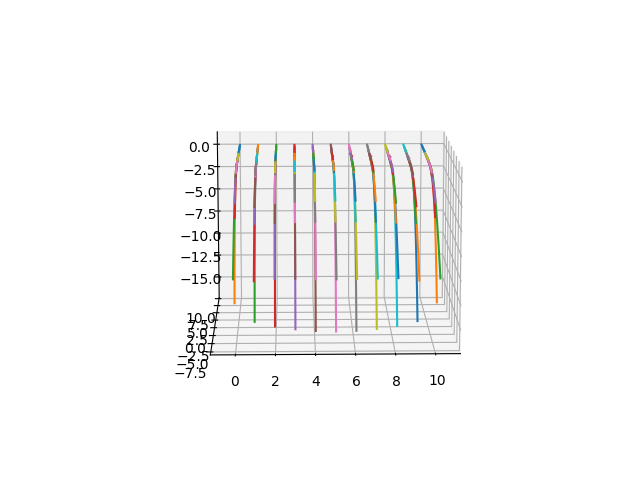

In [22]:
% matplotlib notebook

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Use add_subplot() instead of plt.axes()

# Set axes limits
ax.set_xlim([-1, 11])
ax.set_ylim([-8, 10])
ax.set_zlim([-17, 1])

# plot pathlines for each point
for i in positions1:
    a = np.array(i).T
    plt.plot(a[0], a[1], a[2], '-')

# # remove comment here, to plot streaklines instead
# for i in pc:
#     a = np.array(i).T
#     plt.plot(a[0], a[1], a[2], '.-')



### HOVER CASE

In [5]:
def reshuffle(points, n_r, n_c):
    new=[]
    for i in range(n_c-1):
        for j in range(n_r):
            new.append(points[i+(n_c-1)*j])
    return new

# function to rotate any velocities or vorticities by a given angle
def rotation(velocity, angle=3):
    angle_rad = math.radians(angle)

    vx = velocity[0]
    vy = velocity[1]
    vx_prime = vx * math.cos(angle_rad) - vy * math.sin(angle_rad)
    vy_prime = vx * math.sin(angle_rad) + vy * math.cos(angle_rad)

    magnitude = math.sqrt(vx_prime**2 + vy_prime**2)
    scale_factor = magnitude / math.sqrt(vx**2 + vy**2)
    vx_prime *= scale_factor
    vy_prime *= scale_factor

    return (np.array([vx_prime, vy_prime, velocity[2]]))


In [13]:
# Define parameters
r_min = 2  # minimum radius
r_max = 15  # maximum radius
n_r = 9  # number of segments in radius
n_c = 13  # number of segments in circle

# Create arrays for radius, height, and circle
radius = np.linspace(r_min, r_max, n_r)
circle = np.linspace(0, 2*np.pi, n_c)[:-1]

# Create empty array to store points
points = np.empty((n_r * (n_c-1), 3))
velocitys = np.empty((n_r * (n_c-1), 3))

# Loop through radius, height, and circle to create points
i = 0
for r in radius:
    for j, c in enumerate(circle):
        x = r * np.cos(c)
        y = r * np.sin(c)
        points[i] = [x, y, 0]
        # Compute tangent vector to circle
        tangent = np.array([-np.sin(c), np.cos(c), 0])
        # Normalize tangent vector to obtain unit velocity
        velocity =  0.05457*r* tangent / np.linalg.norm(tangent)
        velocitys[i] = velocity
        i += 1
        
# this part of code is similar to the fixed wing case where we define velocities and vorticities 
# for each grid point and points on the wing
points = reshuffle(points, n_r, n_c)
wing=list((np.array(points[:9]) +np.array(points[-9:]))/2)
for i in range(len(wing)):
    wing[i][-1]=0.1
points=np.array(wing+points)
velocitys = reshuffle(velocitys, n_r, n_c)
wingvel=list(   (  np.array(velocitys[:9]) +np.array(velocitys[-9:])  )/2   )
vel0=np.array(wingvel+list(velocitys))



In [14]:
positions=[[] for i in range(len(points))]

alphax=[[0.2*(i+1),0, 0] for i in range(9)]
alphax[-1][0]=0.2
alphax[-2][0]=0.8

alphax=[rotation(i, angle=-15) for i in alphax]

alpha0=np.array(alphax+ [[0,0,0] for _ in range(len(points)-9)])
for i in range(len(points)):
    positions[i].append(np.array(points[i]))
    

# time marching part of code
for i in tqdm(range(130)):
    k=velocities(points[:9*int(i/12 +0.5 +1)], alpha0[:9*int(i/12 +0.5 +1)], vel0[:9*int(i/12 +0.5 +1)])
    
    # we keep the velocity and vorticities of the wing constant with time, and we allow those of the grid points
    # to be updated with time.
    # all velocities and vorticities are rotated by a fixed angle (3 degrees) with each time step, to account 
    # for the rotation of the wing
    
    k[0][:9]=[rotation(vel0[i]) for i in range(9)]
    k[1][:9]=alphax  
    
    points[:9*int(i/12 +0.5 +1)]+=np.array(k[0])
    vel0[:9*int(i/12 +0.5 +1)]=k[0]
    vel0[:9*int(i/12 +0.5 +1)]=np.array([rotation(i) for i in vel0[:9*int(i/12 +0.5 +1)]])
    vel0[:9]=np.array(k[0][:9])
    alpha0[:9*int(i/12 +0.5 +1)]=[rotation(k[1][i]) for i in range(len(k[1]))]
    
    for j in range(len(points[:9*int(i/12 +0.5 +1)])):        
        positions[j].append(np.array(points[j]))

positions2=positions.copy()

100%|██████████| 130/130 [11:01<00:00,  5.09s/it]


In [15]:
pos_copy=[i[-1] for i in positions2[9:]]
pc=[[] for _ in range(9)]
for i in range(len(pos_copy)):
    pc[i%9].append(pos_copy[i])

<IPython.core.display.Javascript object>


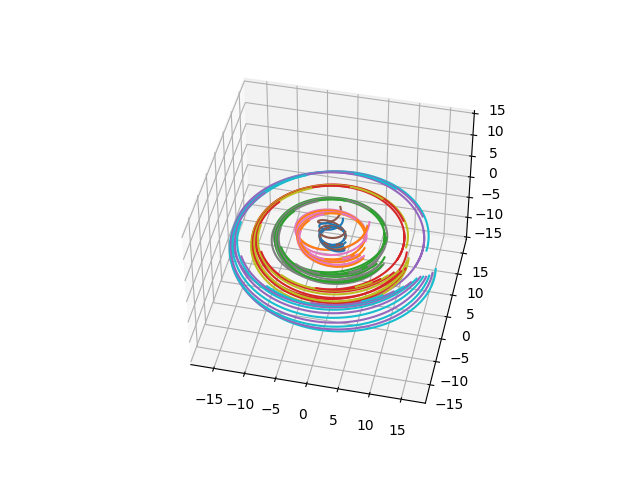

In [23]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

# Set axes limits
# ax.set_xlim([-1, 11])
# ax.set_ylim([-4, 4])
ax.set_zlim([-15, 15])

    
for i in range(len(positions2[9:])):
    if i%9 in [0,2,4,6,8]:
        a = np.array(positions2[i]).T
        plt.plot(a[0], a[1], a[2], '-')
